# Visualize the non-linear dynamics of action potential using the simple FitzHugh-Nagumo model

In [1]:
using Pkg
Pkg.activate("../")
using DynamicalSystems
using DifferentialEquations
using CairoMakie

  Activating project at `~/git/projects/perspective_heart_and_brain`


In [2]:
Dt = 1e-3
# Differential equations of fitzhugh-nagumo model
# References:
# Datseris & Parliz, Nonlinear Dynamics, 2022
# see also: https://link.springer.com/referenceworkentry/10.1007/978-1-4614-7320-6_147-1
# Original: https://www.cell.com/biophysj/pdf/S0006-3495(61)86902-6.pdf
function fitzhugh_nagumo_datseris_parlitz(;a=3, b=0.2, ϵ=0.01, return_nullclines=false)
    function f(u, p, t)
        v, w = u
        I, = p
        dv = a*v*(v-b)*(1-v) - w + I(t)
        dw = ϵ*(v-w)
        return SVector(dv, dw)
    end
    if return_nullclines
        w1(v) = a*v*(v-b)*(1-v)
        w2(v) = v
        return f, w1, w2
    end
    return f
end
function fitzhugh_nagumo_wikipedia(;a=0.7, b=0.8, τ=12.5, return_nullclines=false)
        function f(u, p, t)
            v, w = u
            I, = p
            dv = v - v^3/3 - w + I(t)
            dw = (v + a - b*w)/τ
            return SVector(dv, dw)
        end
        if return_nullclines
            w1(v) = v - v^3/3
            w2(v) = (v + a)/b
            return f, w1, w2
        end
        return f
    end

fitzhugh_nagumo_wikipedia (generic function with 1 method)

In [3]:
f, w1, w2 = fitzhugh_nagumo_datseris_parlitz(ϵ=0.05, b=0.1, return_nullclines=true)

(f, w1, w2)

In [4]:
using ChaosTools
# get the fixed points
fhn = CoupledODEs(f, [0.0, 0.0], [x-> 0, ])
fp,_ = fixedpoints(fhn, IntervalBox(interval(-3,1), interval(-1,1)))
print("fixed points: ", fp[1])


fixed points: [8.330343701897909e-29, 8.321439534045496e-29]

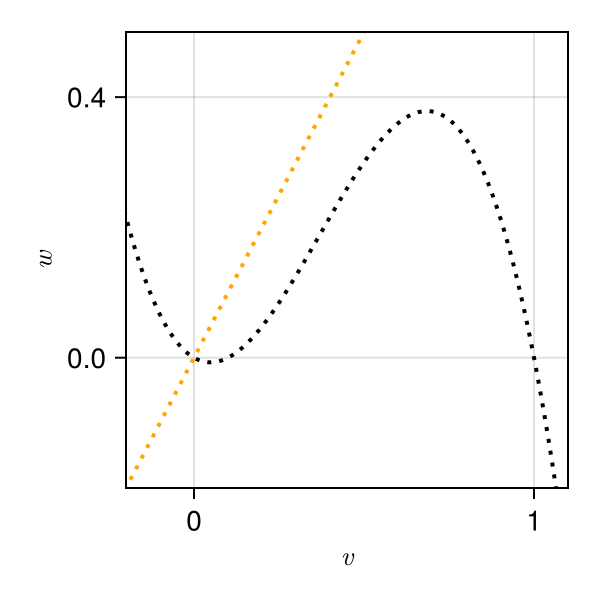

In [5]:
# Draw the state space of the model with nullclines
fig = Figure(size = (300, 300))
ax = Axis(fig[1, 1], xlabel = L"$v$", ylabel = L"$w$", xticks = 0:1:1, yticks = 0:0.4:0.4)
# Draw the nullclines
v = -2:0.01:2
lines!(ax, v, w1.(v), color = :black, linewidth = 2, linestyle = :dot, label = "w1")
lines!(ax, v, w2.(v), color = :orange, linewidth = 2, linestyle = :dot, label = "w2")
xlims!(ax, -0.2, 1.1)
ylims!(ax, -0.2, 0.5)
# draw vector field (TODO)
# draw perturbations (TODO)
fig


In [6]:
# single action potential
u0=fp[1]
stimulus(t) = 10<t<12 ? 0.2 : 0.0
p = [stimulus,]
prob = ODEProblem(f, u0, (0,75), p)
sol = solve(prob, dtmax=1.0, saveat=0.01)
t = sol.t;
v = map(x->x[1], sol.u);


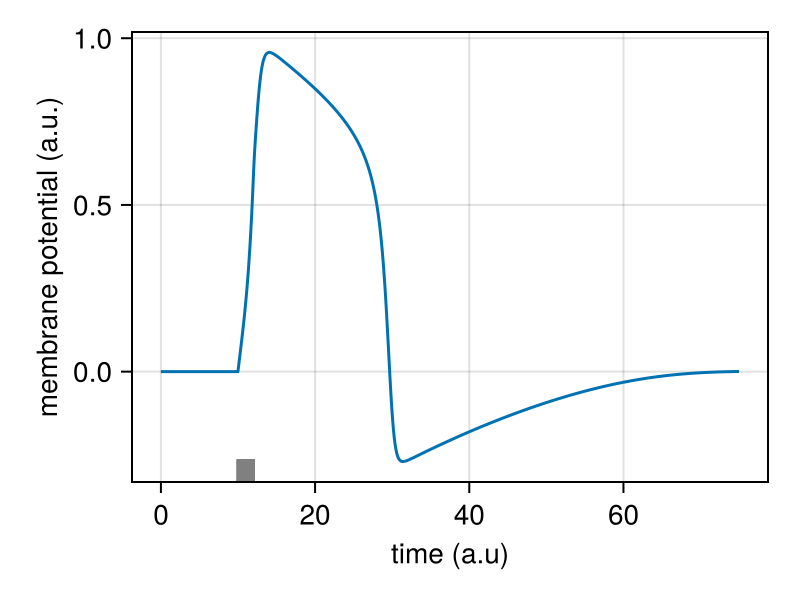

In [7]:
fig = Figure(size = (400, 300))
ax = Axis(fig[1, 1]; xlabel = "time (a.u)", ylabel = "membrane potential (a.u.)")
lines!(ax, t, v)
# plot non-zero stimulus as gray area in the plot
stimulus_t = t[stimulus.(t) .> 0]
stimulus_v = ones(length(stimulus_t)) * (fp[1][1] - 0.1)
vlines!(ax, stimulus_t, ymin=0.0, ymax=0.05, color = :gray)
# save as pdf
save("action_potential_fitzhugh_nagumo_single.pdf", fig)
fig

In [14]:
function I_stim(t)
    if 2 < t <= 3
        return 0.1
    elseif 21 < t <= 22
        return 0.2
    elseif 51 < t <= 52
        return 0.2
    else
        return 0.0
    end
end

# fixed point
u0=fp[1]
p = [I_stim,]
prob = ODEProblem(f, u0, (0,75), p)
sol = solve(prob, dtmax=1.0, saveat=0.01)
t = sol.t;
v = map(x->x[1], sol.u);
w = map(x->x[2], sol.u);

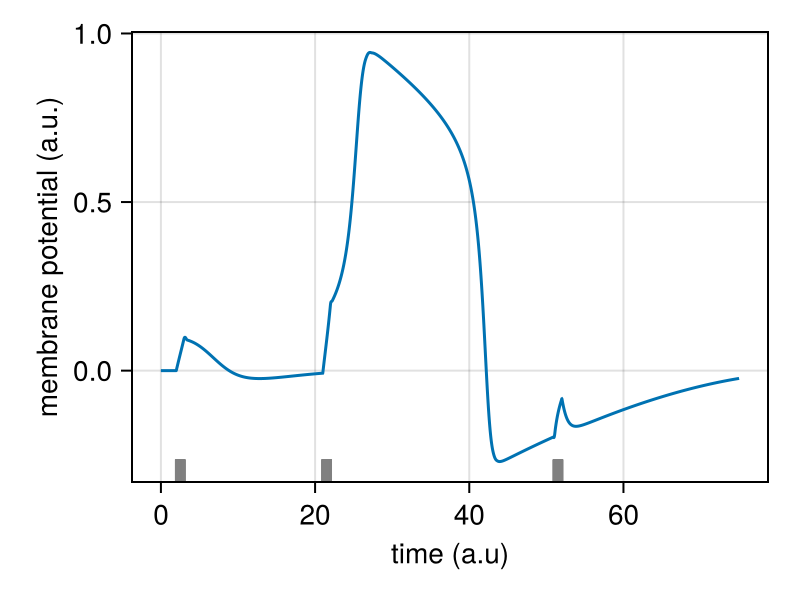

In [15]:
fig = Figure(size = (400, 300))
ax = Axis(fig[1, 1]; xlabel = "time (a.u)", ylabel = "membrane potential (a.u.)")
# plot non-zero stimulus as gray area in the plot
stimulus_t = t[I_stim.(t) .> 0]
stimulus_v = ones(length(stimulus_t)) * (fp[1][1] - 0.1)
vlines!(ax, stimulus_t, ymin=0.0, ymax=0.05, color = :gray)
# plot membrane potential
lines!(ax, t, v)
# save as pdf
save("action_potential_fitzhugh_nagumo_multiple.pdf", fig)
fig

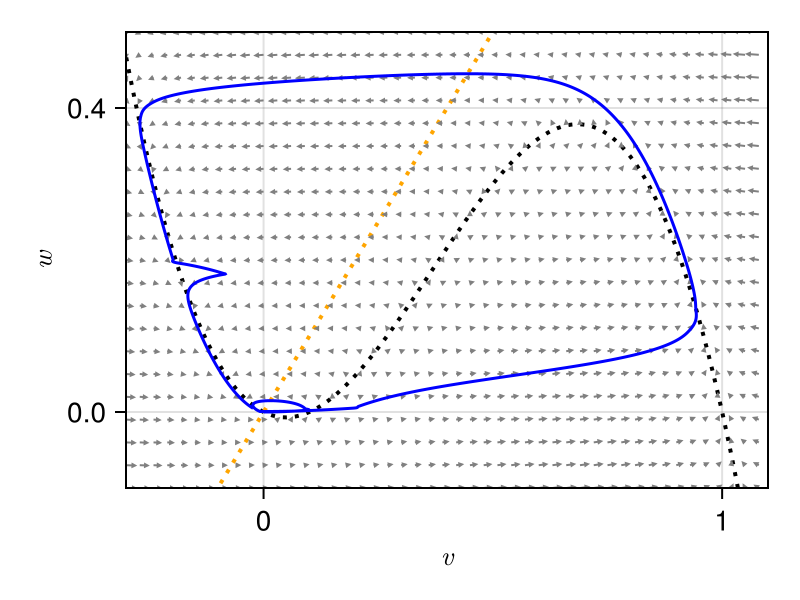

In [19]:
# plot phase space
# Draw the state space of the model with nullclines
fig = Figure(size = (400, 300))
ax = Axis(fig[1, 1], xlabel = L"$v$", ylabel = L"$w$", xticks = 0:1:1, yticks = 0:0.4:0.4)
# Draw the nullclines
vs = -2:0.01:2
lines!(ax, vs, w1.(vs), color = :black, linewidth = 2, linestyle = :dot, label = "w1")
lines!(ax, vs, w2.(vs), color = :orange, linewidth = 2, linestyle = :dot, label = "w2")
xlims!(ax, -0.3, 1.1)
ylims!(ax, -0.1, 0.5)
# plot a grid of vectors that encode the strenght of f(v, w)
# grid
step=0.03
grid_v = -0.3:step:1.1
grid_w = -0.1:step:0.5
for v_ in grid_v, w_ in grid_w
    p=[x->0,]
    dv, dw = f([v_, w_], p, 0)
    # draw errors (dv,dw) at grid points
    arrows!(ax, [v_], [w_], [dv*step], [step*dw], color = :gray, arrowsize=4)
end

lines!(ax, v, w, color = :blue)
lines!(ax, [u0[1]], [u0[2]], color = :red)
fig